In [1]:
import PySO
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import multivariate_normal
import matplotlib.animation as animation
import ffmpeg
import matplotlib 
matplotlib.rcParams.update({'font.size': 22})

In [2]:
def Rastrigin_func(params):
    '''

    Rastrigin function, flipped upside down (since we are searchinf for maxima), as a test function for hierarchical swarm optimization

    INPUTS:
    ------
    params: numpy array shape (#data_points, #dimensions)
        positions to evaluate the Rastrigin function on
        
    RETURNS:
    ------
    f: numpy array (#data_points,)
        Rastrigin function evaluated on all the positions provided
    '''
    f = -(10*params.shape[1]+np.sum(params**2-10*np.cos(2*np.pi*params),axis=1))
    return(f)

Visualising the function:

In [3]:
%matplotlib inline

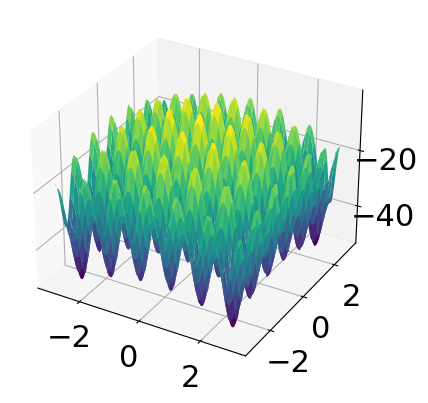

In [4]:
x = np.linspace(-3,3,1000)
y = np.linspace(-3,3,1000)

X, Y = np.meshgrid(x,y)

params = np.stack((X.flatten(),Y.flatten())).T
func_vals = Rastrigin_func(params).reshape(1000,1000)


fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, func_vals ,cmap='viridis', edgecolor='none')

plt.show()

In [5]:

import PySO

class Tempered_PSO(PySO.Model):
    """
    Tempered Heirarchical likelihood PSO for the Rastrigin_function
    """
    names =['x','y']   
    
    
    # Hardcoded bounds for now 
    bounds   = [[-3,3],
                [-3,3]]
    
    def __init__(self,segment_number):
        
        # In the language of tempering, segment number corresponds roughly to the "temperature"
        self.segment_number = segment_number
        
        # At the lowest segment in this case just go back to the original function without tempering
        if self.segment_number == 1:
            self.log_likelihood = self.log_likelihood_final

    def log_likelihood(self, params):
        '''
        Tempered Rastrigin likelihood 
        '''
        parameters_array = np.array([params[key] for key in list(params.keys())])
        
        func_vals = -(10*len(parameters_array)+np.sum(parameters_array**2-10*np.cos(2*np.pi*parameters_array)))
        
        Semi_Co_Log_L = np.exp((func_vals)/self.segment_number)
        
        if Semi_Co_Log_L == -np.inf: print(params)

        return(Semi_Co_Log_L)
        
        
    def log_likelihood_final(self, params):
        '''
        Original Rastrigin likelihood
        '''
        parameters_array = np.array([params[key] for key in list(params.keys())])
        
        func_vals = -(10*len(parameters_array)+np.sum(parameters_array**2-10*np.cos(2*np.pi*parameters_array)))
        
        return(func_vals)
        

In [6]:
import os

Numparticles = 2000

outdir = 'hierarchical_results/'

models = [Tempered_PSO(i) for i in range(20,0,-5)]
# Appending the original model at the end 
models.append(Tempered_PSO(1))
# These parameters are a "sensible" initial guess for now which lets us find some of the secondaries 

Omega = [1.0,0.6,0.5,0.5,0.5]
Phip = [1.2,0.7,0.6,0.5,0.5]
Phig = [0.2,0.0,0.5,0.6,0.7]
Mh_fraction = [0.0,0.0,0.0,0.0,0.0]
# Go into the right rough region, dont be TOO clustered-> Cognitive only PSO maps out the peaks close in the right rough region, then normal PSO with more and 
#    more weight on the group aspect. 
minimum_velocities = [0.000001,0.000001]

# Contains the common key word arguments that go to each swarm
swarm_kwargs = {'Verbose':False, 'Nthreads':5 , 'Periodic':[0,0],'Velocity_min': minimum_velocities}

Heirachial_Swarms = PySO.HierarchicalSwarmHandler(models,
                                                  1,
                                                  Numparticles,
                                                  Omega = Omega, 
                                                  Phip = Phip, 
                                                  Phig = Phig,
                                                  Mh_fraction = Mh_fraction,
                                                  Swarm_kwargs= swarm_kwargs,
                                                  Output = outdir, 
                                                  Nperiodiccheckpoint=1,
                                                  Verbose=False,
                                                  Saveevolution=True, 
                                                  Minimum_exploration_iterations=70,
                                                  Initial_exploration_limit=30,
                                                  Maximum_number_of_iterations_per_step=150,
                                                  Kick_velocities=False, 
                                                  Use_func_vals_in_clustering= False,
                                                  Max_particles_per_swarm=200)

history_file = os.path.join(outdir, "EnsembleEvolutionHistory.dat")
if os.path.isfile(history_file): os.system('rm {}'.format(history_file))

Heirachial_Swarms.Run()


Stability number: 1.3
Swarm initialisation finished....

 Swarm  0  reached stall condition, freezing

 All swarms stalled! Switching segments from  20  to  15
Reinitiating swarms with Omega:  0.6  PhiP:  0.7  PhiG:  0.0
Stability number: 1.25

 Swarm  0  reached stall condition, freezing

 Swarm  1  reached stall condition, freezing

 Swarm  2  reached stall condition, freezing

 Swarm  3  reached stall condition, freezing

 Swarm  4  reached stall condition, freezing

 Swarm  5  reached stall condition, freezing

 Swarm  6  reached stall condition, freezing

 Swarm  7  reached stall condition, freezing

 Swarm  8  reached stall condition, freezing

 Swarm  9  reached stall condition, freezing

 Swarm  10  reached stall condition, freezing

 Swarm  11  reached stall condition, freezing

 Swarm  12  reached stall condition, freezing

 Swarm  13  reached stall condition, freezing

 Swarm  14  reached stall condition, freezing

 Swarm  15  reached stall condition, freezing

 All swarms s

In [8]:
# Reading in the results file 
import pandas as pd
history_file = pd.read_csv('hierarchical_results/EnsembleEvolutionHistory.dat')
heirarchical_steps = np.unique(history_file['HierarchicalModelNumber'])
iterations = np.unique(history_file['IterationNumber'])


In [9]:
# Recomputing the Rastrigin function over a smaller domain corresponding to the PSO domain for visualisation in following animation

x = np.linspace(-3,3,1000)
y = np.linspace(-3,3,1000)

X, Y = np.meshgrid(x,y)

params = np.stack((X.flatten(),Y.flatten())).T
func_vals = Rastrigin_func(params).reshape(1000,1000)

In [10]:
# Pre processing the results file in prep for the aimation 

heirachial_subsets = []
heirachial_subset_iteration_limits = []
num_swarm_in_each_subset = []
colour_maps = []
for heirachial_model_counter in heirarchical_steps:
    
    # Seperating the results file by the different segment sections 
    heirachial_subset = history_file[history_file['HierarchicalModelNumber'] == heirachial_model_counter]
    heirachial_subsets.append(heirachial_subset)
    # Number of swarms in each segment section 
    num_swarm_in_each_subset.append(len(np.unique(heirachial_subset['swarm_number'])))
    # Iteration range for each segment section 
    heirachial_subset_iteration_limits.append([np.min(heirachial_subset['IterationNumber']),
                    np.max(heirachial_subset['IterationNumber'])])
    # Generate colour map for each segment with N (number of swarms) different colours 
    colour_maps.append(plt.cm.get_cmap('gist_rainbow',num_swarm_in_each_subset[-1]))

heirachial_subset_iteration_limits = np.array(heirachial_subset_iteration_limits)


/tmp/ipykernel_9489/2747016210.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colour_maps.append(plt.cm.get_cmap('gist_rainbow',num_swarm_in_each_subset[-1]))


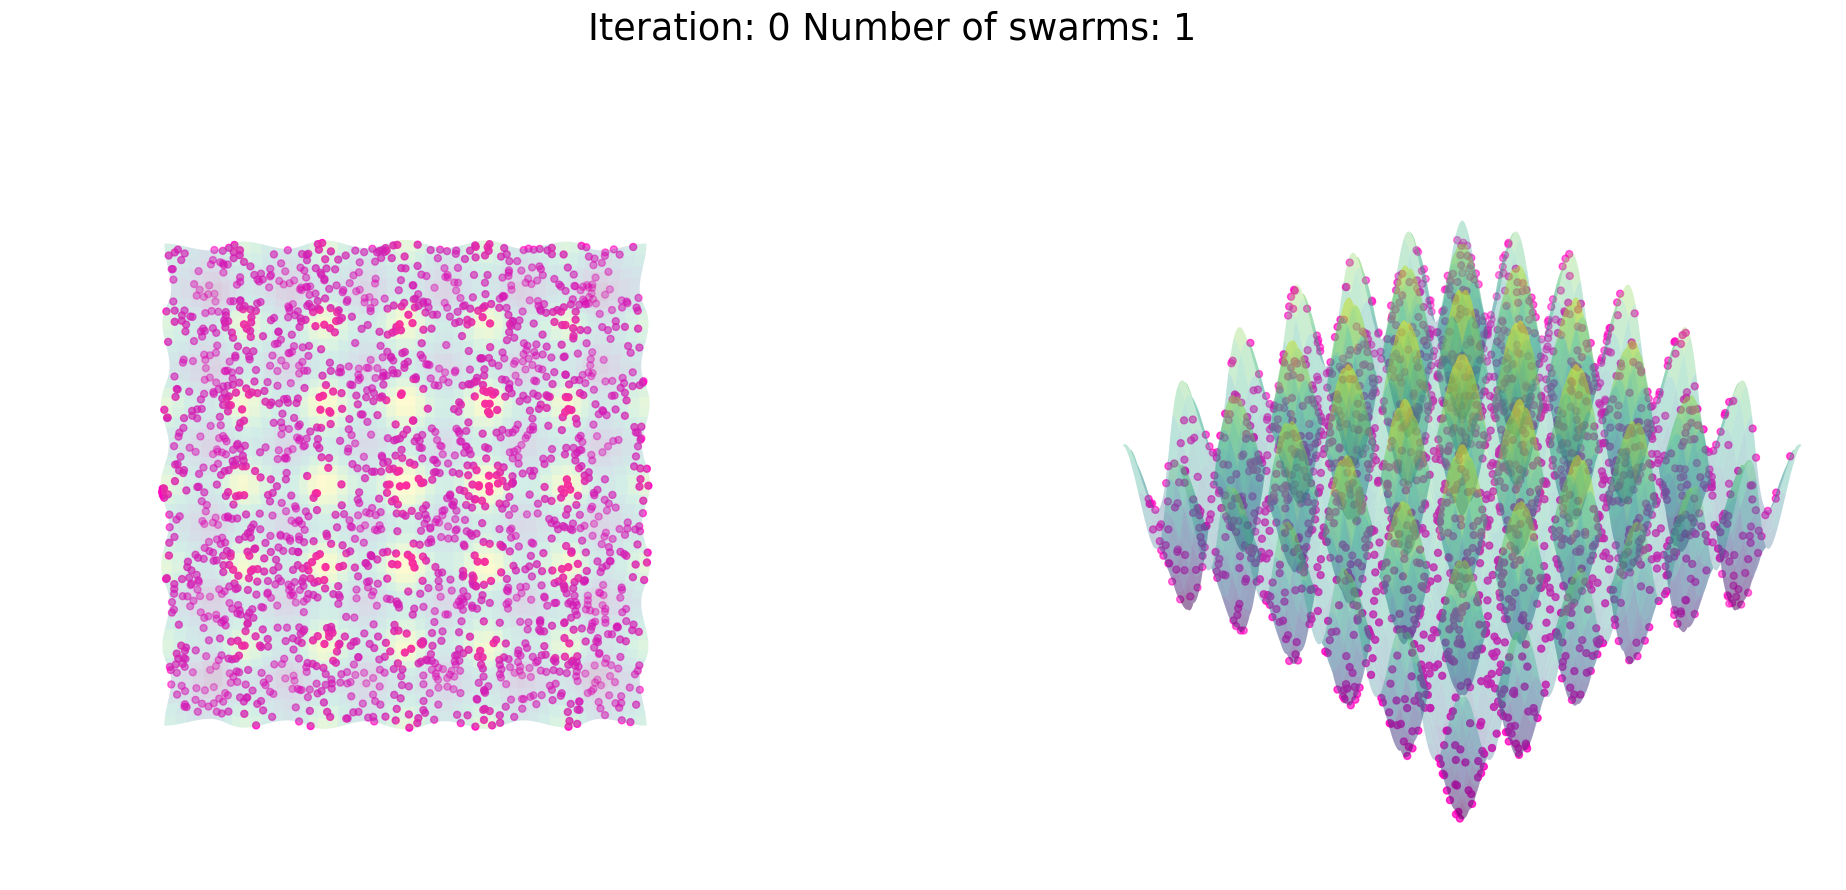

In [11]:
## Animation

fig = plt.figure(figsize=(25,10))
ax_vertical = fig.add_subplot(121,projection='3d')
ax_vertical.view_init(azim=0, elev=90)
ax_side = fig.add_subplot(122,projection='3d')


def animate(iteration):
    # Find which segment we are in 
    heirachy_index = np.arange(heirachial_subset_iteration_limits.shape[0])[(iteration>=heirachial_subset_iteration_limits[:,0])
                                                            & (iteration<=heirachial_subset_iteration_limits[:,1])][0]
    
    
    # Plotting limits etc 
    ax_vertical.clear()
    ax_side.clear()
    
    ax_vertical.set_xlim(-3,3)
    ax_vertical.set_ylim(-3,3)
    ax_vertical.set_zlim(-52,0)
    
    # azimuthal angle rotation over time 
    ax_side.view_init(azim=45+iteration, elev=45)
    ax_side.set_xlim(-3,3)
    ax_side.set_ylim(-3,3)
    ax_side.set_zlim(-52,0)
    
    
    # Select colour map for corresponding segment 
    heirachical_colour_map = colour_maps[heirachy_index]
    
    fig.suptitle('Iteration: '+str(iteration)+' Number of swarms: '+str(num_swarm_in_each_subset[heirachy_index]))
    
    # On both plots, plot the surface we are trying to optimize
    ax_vertical.plot_surface(X, Y, func_vals ,cmap='viridis', edgecolor='none',alpha=0.2,zorder=0)
    ax_side.plot_surface(X, Y, func_vals ,cmap='viridis', edgecolor='none',alpha=0.3,zorder=0)
    
    # Pick the dataframe for the segment we are in 
    df = heirachial_subsets[heirachy_index]
    
    # Filter to current iteration 
    iteration_dataframe = df[df['IterationNumber'] == iteration]
        

    # For each swarm in this iteration (including frozen ones)
    for swarm_index in range(num_swarm_in_each_subset[heirachy_index]):
        
        # Filter to specific swarm 
        df = iteration_dataframe[iteration_dataframe['swarm_number'] == swarm_index]
         
        # Extract positions and calculate scatter function values 
        positions = np.array([df['x'].to_numpy(),df['y'].to_numpy()]).T
        scatter_func_vals= Rastrigin_func(positions)
        
        # Plot positions and values on both plots 
        ax_vertical.scatter(df['x'],df['y'],scatter_func_vals,color=heirachical_colour_map(swarm_index),s=25,zorder=1)
        ax_side.scatter(df['x'],df['y'],scatter_func_vals,color=heirachical_colour_map(swarm_index),s=25,zorder=1,
                        label='Swarm Number: '+str(swarm_index)+' Particles: ' + str(positions.shape[0]))
    
    # plt.legend(loc=(1,0.9))    
    ax_vertical.axis('off')
    ax_side.axis('off')
    # plt.savefig('temp/'+str(iteration)+'.pdf')

ani = animation.FuncAnimation(fig, animate, interval=1, frames=np.max(iterations))
ani.save('hierarchical_results/animation_non_periodic.gif', writer='ffmpeg',fps=10)
